<a href="https://colab.research.google.com/github/Ajaykumar1526/nm-phase3/blob/main/source_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing values:
 gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Basic statistics:
        math score  reading score  writing score  total_score  average_score
count  1000.000000    1000.000000    1000.000000  1000.000000    1000.000000
mean     67.810000      70.382000      69.140000   207.332000      69.110667
std      15.250196      14.107413      15.025917    42.083569      14.027856
min      15.000000      25.000000      15.000000    60.000000      20.000000
25%      58.000000      61.000000      59.000000   178.750000      59.583333
50%      68.000000      70.500000      70.000000   209.000000      69.666667
75%      79.250000      80.000000      80.000000   238.000000      79.333333
max     100.000000     100.000000     100.000000   300.000000     100.0

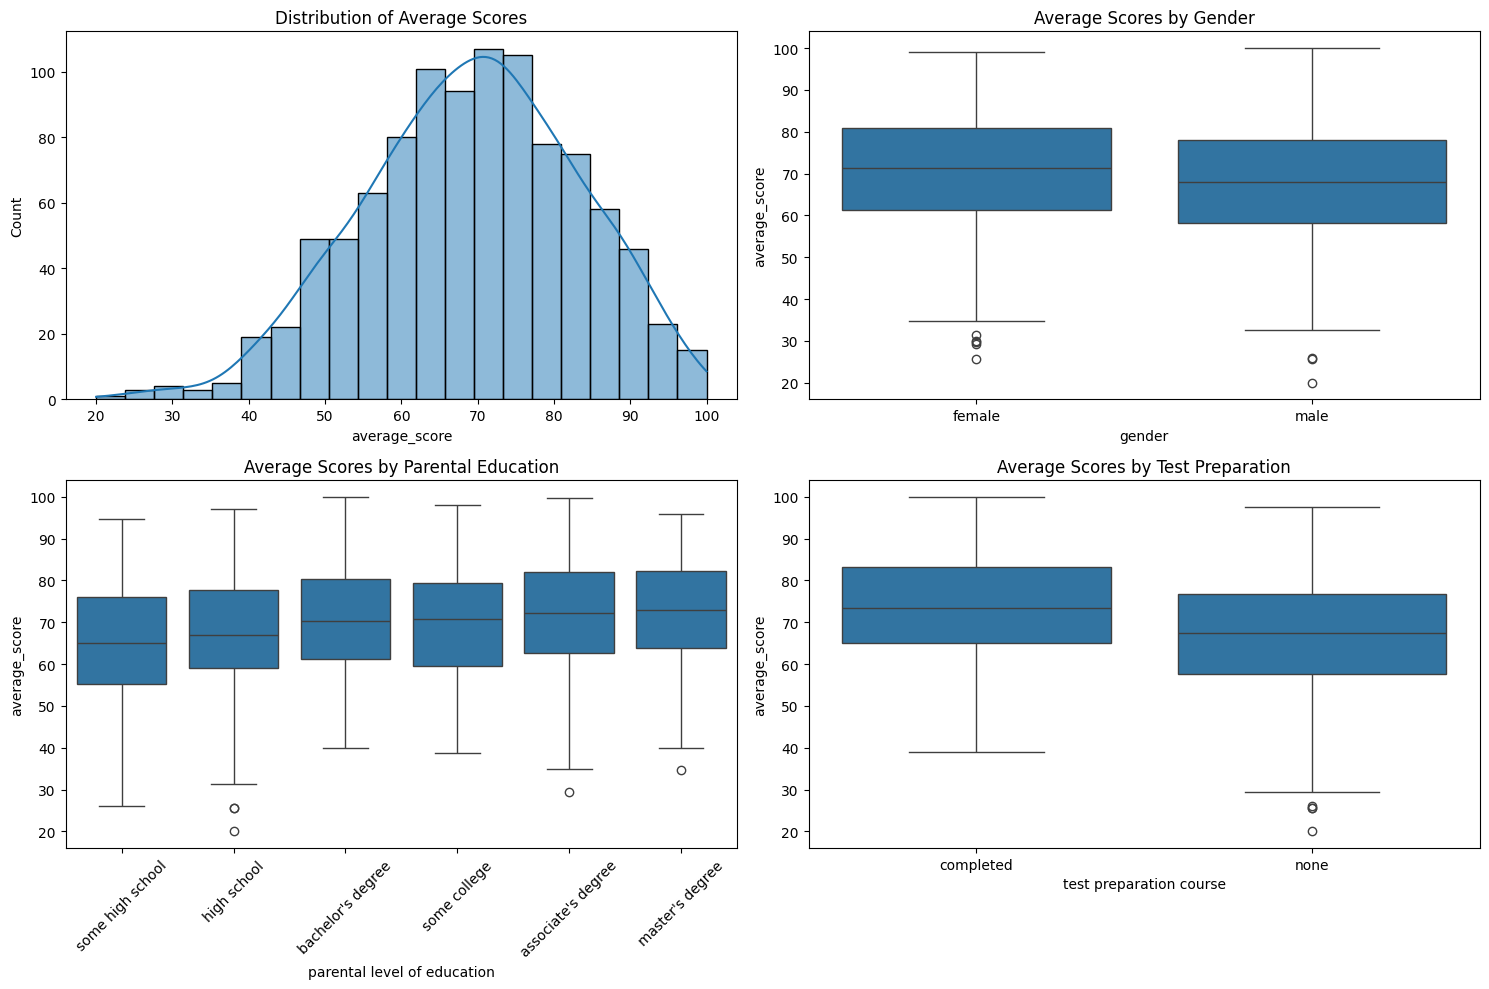

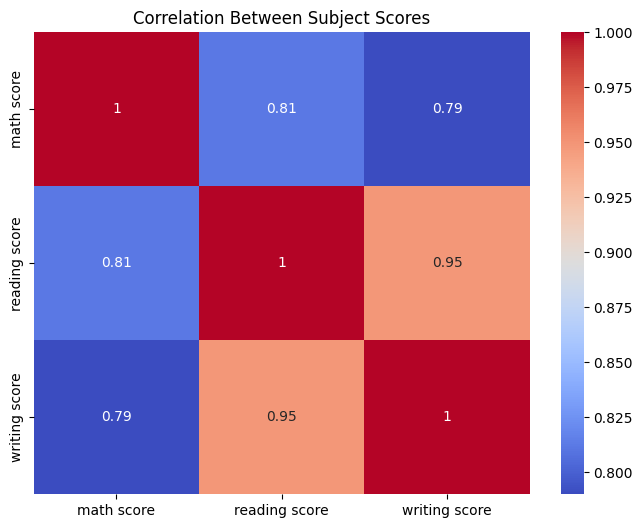


Model Performance:
RMSE: 12.51
R-squared: 0.08


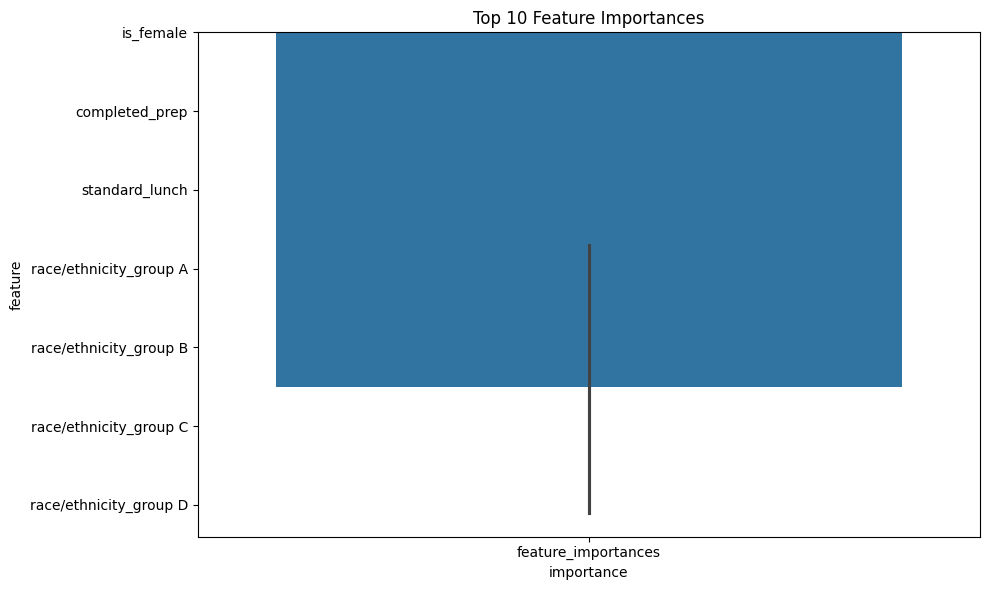


Predicted average score for sample student: 67.1


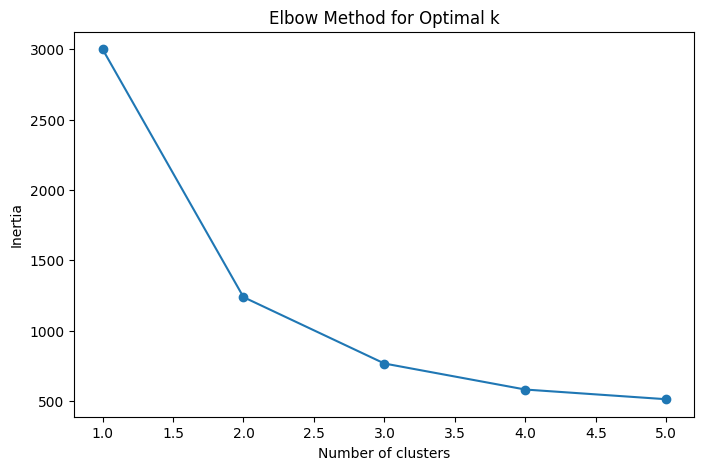

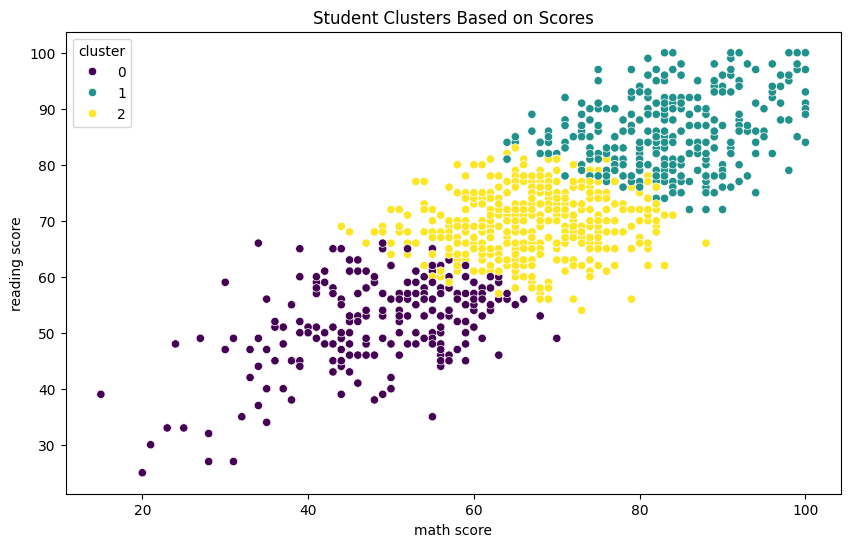


Cluster Score Averages:
         math score  reading score  writing score
cluster                                          
0         49.128099      52.235537      49.913223
1         83.512821      85.919872      85.240385
2         66.961883      69.358744      68.309417


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('exams.csv')


# Data Preprocessing


# Check for missing values
print("Missing values:\n", df.isnull().sum())

# No missing values found in this dataset

# Feature engineering - create total score and average score
df['total_score'] = df['math score'] + df['reading score'] + df['writing score']
df['average_score'] = df['total_score'] / 3

# Convert categorical columns to proper data types
cat_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for col in cat_cols:
    df[col] = df[col].astype('category')


# Exploratory Data Analysis


# Basic statistics
print("\nBasic statistics:")
print(df.describe())

# Visualizations
plt.figure(figsize=(15, 10))

# Distribution of scores
plt.subplot(2, 2, 1)
sns.histplot(df['average_score'], kde=True)
plt.title('Distribution of Average Scores')

# Scores by gender
plt.subplot(2, 2, 2)
sns.boxplot(x='gender', y='average_score', data=df)
plt.title('Average Scores by Gender')

# Scores by parental education
plt.subplot(2, 2, 3)
order = df.groupby('parental level of education')['average_score'].median().sort_values().index
sns.boxplot(x='parental level of education', y='average_score', data=df, order=order)
plt.xticks(rotation=45)
plt.title('Average Scores by Parental Education')

# Scores by test preparation
plt.subplot(2, 2, 4)
sns.boxplot(x='test preparation course', y='average_score', data=df)
plt.title('Average Scores by Test Preparation')

plt.tight_layout()
plt.show()

# Correlation between scores
plt.figure(figsize=(8, 6))
sns.heatmap(df[['math score', 'reading score', 'writing score']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Subject Scores')
plt.show()


# Feature Engineering


# Create binary features
df['completed_prep'] = df['test preparation course'].apply(lambda x: 1 if x == 'completed' else 0)
df['standard_lunch'] = df['lunch'].apply(lambda x: 1 if x == 'standard' else 0)
df['is_female'] = df['gender'].apply(lambda x: 1 if x == 'female' else 0)


# Data Preparation for Modeling


# Define features and target
X = df.drop(['math score', 'reading score', 'writing score', 'total_score', 'average_score'], axis=1)
y = df['average_score']  # Could also predict individual subjects

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = []  # We've created binary features for modeling
categorical_features = ['race/ethnicity', 'parental level of education']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Model Training


# Create pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train model
model.fit(X_train, y_train)


# Model Evaluation


# Predictions
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

# Feature importance
feature_names = (model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features))

feature_importances = model.named_steps['regressor'].feature_importances_

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'feature': ['is_female', 'completed_prep', 'standard_lunch'] + list(feature_names),
    'importance': 'feature_importances'
}).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()


# Model Deployment Preparation


# Save the model
joblib.dump(model, 'exam_score_predictor.pkl')

# Example of loading and using the model
loaded_model = joblib.load('exam_score_predictor.pkl')

# Create sample input for prediction
sample_input = pd.DataFrame({
    'gender': ['female'],
    'race/ethnicity': ['group C'],
    'parental level of education': ["bachelor's degree"],
    'lunch': ['standard'],
    'test preparation course': ['completed']
})

# Make prediction
predicted_score = loaded_model.predict(sample_input)
print(f"\nPredicted average score for sample student: {predicted_score[0]:.1f}")


# Additional Analysis (Optional)


# Cluster analysis of students
from sklearn.cluster import KMeans

# Prepare data for clustering
cluster_features = df[['math score', 'reading score', 'writing score']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

# Find optimal number of clusters using elbow method
inertia = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Apply K-means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='math score', y='reading score', hue='cluster', data=df, palette='viridis')
plt.title('Student Clusters Based on Scores')
plt.show()

# Analyze cluster characteristics
cluster_summary = df.groupby('cluster')[['math score', 'reading score', 'writing score']].mean()
print("\nCluster Score Averages:")
print(cluster_summary)